
✅ Using device: cpu


Device set to use cpu



✅ Training LSTM models...
Epoch 1/150
19/19 [==============================] - 4s 6ms/step - loss: 127963.5469
Epoch 2/150
19/19 [==============================] - 0s 6ms/step - loss: 126831.4062
Epoch 3/150
19/19 [==============================] - 0s 5ms/step - loss: 121181.1641
Epoch 4/150
19/19 [==============================] - 0s 5ms/step - loss: 99789.9844
Epoch 5/150
19/19 [==============================] - 0s 5ms/step - loss: 54789.6680
Epoch 6/150
19/19 [==============================] - 0s 5ms/step - loss: 25772.7148
Epoch 7/150
19/19 [==============================] - 0s 5ms/step - loss: 18531.3809
Epoch 8/150
19/19 [==============================] - 0s 5ms/step - loss: 12301.2695
Epoch 9/150
19/19 [==============================] - 0s 5ms/step - loss: 8085.5034
Epoch 10/150
19/19 [==============================] - 0s 5ms/step - loss: 5631.2686
Epoch 11/150
19/19 [==============================] - 0s 5ms/step - loss: 4404.2856
Epoch 12/150
19/19 [===========================

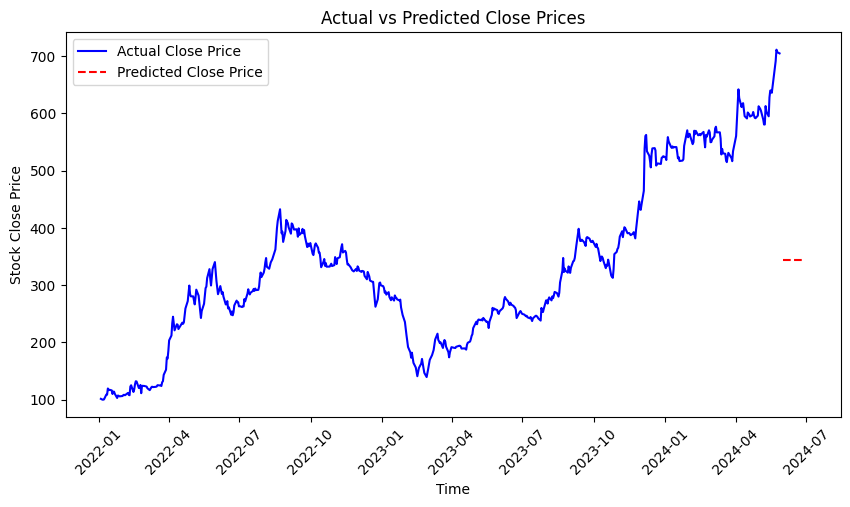


📌 Successfully Loaded Predicted Data
          date  predicted_close  predicted_open
0   2024-06-01       344.221313      354.241333
1   2024-06-02       344.221313      354.241333
2   2024-06-03       344.221313      354.241333
3   2024-06-04       344.221313      354.241333
4   2024-06-05       344.221313      354.241333
5   2024-06-06       344.221313      354.241333
6   2024-06-07       344.221313      354.241333
7   2024-06-08       344.221313      354.241333
8   2024-06-09       344.221313      354.241333
9   2024-06-10       344.221313      354.241333
10  2024-06-11       344.221313      354.241333
11  2024-06-12       344.221313      354.241333
12  2024-06-13       344.221313      354.241333
13  2024-06-14       344.221313      354.241333
14  2024-06-15       344.221313      354.241333
15  2024-06-16       344.221313      354.241333
16  2024-06-17       344.221313      354.241333
17  2024-06-18       344.221313      354.241333
18  2024-06-19       344.221313      354.241333
19

In [5]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from transformers import pipeline
import torch
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ Check Device Availability (CPU/GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n✅ Using device: {device}")

# ✅ Load Stock & News Data
stock_file = "stock_data.csv"
news_file = "news_data.csv"
predicted_file = "predicted_stock_prices.csv"

if not os.path.exists(stock_file) or not os.path.exists(news_file):
    raise FileNotFoundError("\n❌ Error: Stock or News data file not found!")

stock_data = pd.read_csv(stock_file)
news_data = pd.read_csv(news_file)

# ✅ Convert Date Format
stock_data["date"] = pd.to_datetime(stock_data["date"], dayfirst=True, errors="coerce")
news_data["date"] = pd.to_datetime(news_data["date"], dayfirst=True, errors="coerce")

# ✅ Filter Data (Use Only Recent Data 2022–2024)
stock_data = stock_data[stock_data["date"] >= "2022-01-01"]

# ✅ Add Technical Indicators
stock_data["daily_change"] = stock_data["close"] - stock_data["open"]
stock_data["volatility"] = stock_data["high"] - stock_data["low"]
stock_data["50_day_MA"] = stock_data["close"].rolling(window=50).mean()
stock_data["200_day_MA"] = stock_data["close"].rolling(window=200).mean()

# ✅ Load Sentiment Analysis Model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name, device=-1)

# ✅ Apply Sentiment Analysis
def get_sentiment(text):
    result = sentiment_pipeline(text)[0]["label"]
    return 1 if result == "POSITIVE" else (-1 if result == "NEGATIVE" else 0)

news_data["sentiment"] = news_data["news_summary"].apply(get_sentiment)
news_data = news_data.groupby("date").agg({"sentiment": "mean"}).reset_index()

# ✅ Merge Stock Data with Sentiment Data
merged_data = pd.merge(stock_data, news_data, on="date", how="left").fillna(0)

# ✅ Train on Data Up to May 2024
train_data = merged_data[merged_data["date"] < "2024-06-01"]

# ✅ Prepare Features and Targets
features = ["sentiment", "volume", "daily_change", "volatility", "50_day_MA", "200_day_MA"]
X_train = train_data[features]
y_train_close = train_data["close"]
y_train_open = train_data["open"]

# ✅ Apply Standard Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# ✅ Predict Future Data (June 2024)
future_dates = pd.date_range("2024-06-01", periods=30, freq="D")
future_data = pd.DataFrame({"date": future_dates})

# Fill Future Data with Mean Values
for col in features:
    future_data[col] = train_data[col].mean()
X_future = scaler.transform(future_data[features])
X_future = np.reshape(X_future, (X_future.shape[0], 1, X_future.shape[1]))

# ✅ Build Optimized LSTM Model
def build_lstm_model():
    model = Sequential([
        LSTM(256, input_shape=(1, len(features)), return_sequences=False),
        Dense(128, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1)
    ])
    model.compile(loss="mean_squared_error", optimizer="adam")
    return model

# ✅ Train LSTM Models
model_close = build_lstm_model()
model_open = build_lstm_model()

print("\n✅ Training LSTM models...")
model_close.fit(X_train, y_train_close, epochs=150, batch_size=32, verbose=1)
model_open.fit(X_train, y_train_open, epochs=150, batch_size=32, verbose=1)

# ✅ Predict June 2024 Prices
future_close = model_close.predict(X_future)
future_open = model_open.predict(X_future)

# ✅ Apply Inverse Transform Correctly
future_close_expanded = np.zeros((future_close.shape[0], len(features)))
future_open_expanded = np.zeros((future_open.shape[0], len(features)))

# Place predictions in the first column
future_close_expanded[:, 0] = future_close.ravel()
future_open_expanded[:, 0] = future_open.ravel()

# Fill missing columns with mean of training data
future_close_expanded[:, 1:] = np.mean(X_train[:, 0, 1:], axis=0)
future_open_expanded[:, 1:] = np.mean(X_train[:, 0, 1:], axis=0)

# Apply Inverse Transform
future_close = scaler.inverse_transform(future_close_expanded)[:, 0]
future_open = scaler.inverse_transform(future_open_expanded)[:, 0]

# ✅ Save Predictions
predictions_df = pd.DataFrame({
    "date": future_dates,
    "predicted_close": future_close.ravel(),
    "predicted_open": future_open.ravel()
})
predictions_df.to_csv(predicted_file, index=False)
print("\n✅ Predictions for June 2024 Saved Successfully!")
print(predictions_df.head())

# ✅ Model Evaluation
y_pred_close = model_close.predict(X_train)
y_pred_open = model_open.predict(X_train)

mse_close = mean_squared_error(y_train_close, y_pred_close)
mse_open = mean_squared_error(y_train_open, y_pred_open)
mae_close = mean_absolute_error(y_train_close, y_pred_close)
mae_open = mean_absolute_error(y_train_open, y_pred_open)
r2_close = r2_score(y_train_close, y_pred_close)
r2_open = r2_score(y_train_open, y_pred_open)

print(f"\n📊 Model Evaluation Metrics")
print(f"🔹 MSE (Close Price): {mse_close:.4f}")
print(f"🔹 MSE (Open Price): {mse_open:.4f}")
print(f"🔹 MAE (Close Price): {mae_close:.4f}")
print(f"🔹 MAE (Open Price): {mae_open:.4f}")
print(f"🔹 R² Score (Close Price): {r2_close:.4f}")
print(f"🔹 R² Score (Open Price): {r2_open:.4f}")

# ✅ Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 5))
plt.plot(train_data["date"], train_data["close"], label="Actual Close Price", color="blue")
plt.plot(future_dates, future_close, label="Predicted Close Price", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Close Price")
plt.legend()
plt.title("Actual vs Predicted Close Prices")
plt.xticks(rotation=45)
plt.show()

# ✅ Load and Display Predictions
if os.path.exists(predicted_file):
    predicted_df = pd.read_csv(predicted_file)
    print("\n📌 Successfully Loaded Predicted Data")
    print(predicted_df.head(30))  # Show first 30 rows
else:
    print("\n❌ Error: 'predicted_stock_prices.csv' not found!")
